<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/interp/pydata-hh-surrogate-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explaining Deep Neural Networks using Surrogate Models

https://www.meetup.com/en-AU/PyData-Hamburg/events/269007662/

This notebook: http://bit.ly/pydata-surrogate

_Deep Neural Networks generalize well from training data, however, they typically are black boxes and how they come to a conclusion is not comprehensible. Decision Trees can be much more comprehensible but unlike Neural Networks they tend to overfit when trained on real world data and are hard to regularize. But what if we train decision trees on data generated by a neural network tuned for generalization? Our hope is that the high capacity of the deep neural network will be able to do a really good job learning the structures underlying the training data and then be able to be a good teacher to our decision tree. As it turns out, this approach gives us a dial to be tuned between predictive power and explainability that goes all the way from hand crafted rules to deep neural networks._

_Oliver Zeigermann, oliver.zeigermann@gmail.com, https://twitter.com/DJCordhose, https://www.linkedin.com/in/oliver-zeigermann-34989773/_

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/ml_is_not_programming.jpg?raw=1'>

# Motivation: Why explainability matters

.<br>
.<br>
.<br>
.<br>
.<br>
.<br>
.<br>
.<br>
.<br>

## the right to explanation is well established by the GDPR and United States' Credit score
## explainability brings more trust into a decision
## helps debugging
## helps identify unwanted bias 



# Transpareancy as an ethical concern

![Transparency is ethical](https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/salesforce-transparency-ethics.jpg?raw=1)

Richard Socher (https://www.socher.org/) at http://scaledml.org/2020/

# Challenge

1. some models are good for explainability (like decision trees), they tend to overfit
1. other models have great performance (like neural networks), but are black boxes

# Approach

_teach a decision tree using a neural network to fight overfitting, but still having all the benefits of a decision tree_


# Steps Taken

1. Understanding our example
1. Understanding why Decision Trees are inappropriate when trained traditionally
1. Train Neural Network using the data you have and make it generalize well
1. Generate a larger and evenly distributed set of training data by feeding a grid of data through the neural network
1. Use this new training data to train a unregularized decision tree
    1. Decision tree will still overfit, but on data that is already very general (because of step 2)
    1. Scores will show the tree can fit perfectly on generated data
1. Use typical regularization for decision tree not to make it generalize better, but to have a dial between explainability and accuracy
  1. depth
  2. number of leaf nodes
  3. etc.
1. Use tree for explanation
1. Feature Importance and Bias (advanced, not part of this talk, but stil in this notebook)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']

cmap = ListedColormap(colors)

In [2]:
!nvidia-smi

Tue Mar 17 16:24:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [4]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
random_seed = 42

In [0]:
tf.random.set_seed(random_seed)

In [0]:
import numpy as np

np.random.seed(random_seed)

In [0]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

In [0]:
from lrcurve import KerasLearningCurve

In [0]:
import pandas as pd
import numpy as np

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html

from matplotlib.ticker import FuncFormatter

import numpy as np

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 110
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)

def plot_samples(samples, ax, legend):
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
    ax.add_artist(class_legend)
    
    return ax, scatter

def plot_samples_markers(samples, ax, legend):
  y = samples[2]
  bad = samples[y == 0]
  good = samples[y == 1]
  fair = samples[y == 2]

  labels = ["High Risk", "Low Risk", "Medium Risk"]
  classes = [bad, good, fair]
  markers = ['v', 'd', '^']

  for label, clazz, color, marker in zip(labels, classes, colors, markers):
      ax.scatter(
          clazz[0], 
          clazz[1],
          label=label,
          color=color,
          marker=marker,
          s=100,
          edgecolors='k',
          alpha=0.8)
  if legend:
    ax.legend()
  return ax, None
      

def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   n_samples=None, proba=True, prediction=True, legend=True, 
                   scatter=True,
                   X=None,
                   ax=None
                  ):
    if x_data is not None:
      assert x_data.shape == y_data.shape, "x and y must have the same dimension"
    if x_data  is not None and ground_truth is not None:
      assert x_data.shape == ground_truth.shape, "input and ground truth need the same number of samples"
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots()

    if clf:
        if X is not None:
          Z = clf.predict_proba(X)
        else:
          Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    
    if scatter:
      samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
      if n_samples:
        samples = samples.sample(n_samples, random_state=42)
      plot_samples_markers(samples, ax, legend)
    return ax 


In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/insurance-customers-1500.csv', sep=';')
# local
# df = pd.read_csv('../../data/insurance-customers-1500.csv', sep=';')

In [13]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [0]:
# groups: "High Risk", "Low Risk", "Medium Risk"
  
y = df['group'].values
X = df.drop('group', axis='columns').values

# Step 1: Understanding our example

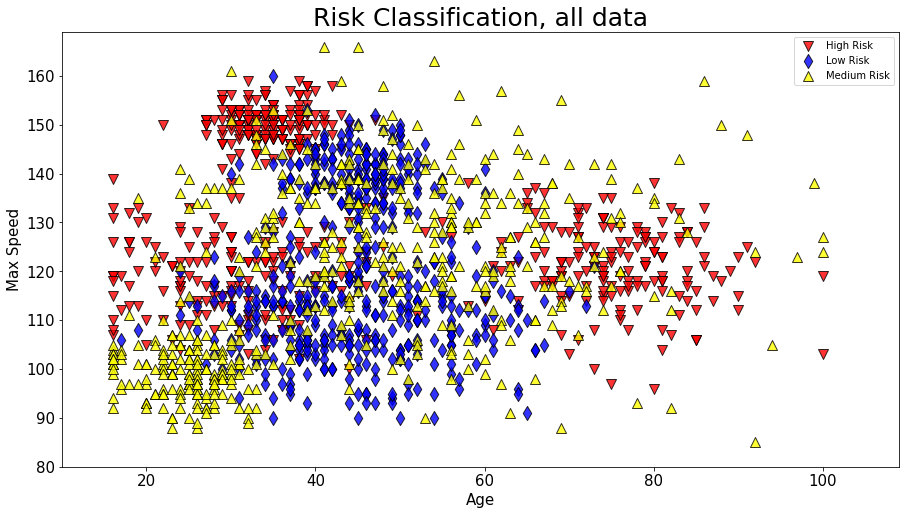

In [15]:
plotPrediction(clf=None, x_data=X[:, 1], y_data=X[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y,
                title="Risk Classification, all data");

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_seed, stratify=y)

## We just use the first two variables

In [0]:
# just the first two dimensions
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]
X_2_dim = X[:, :2]

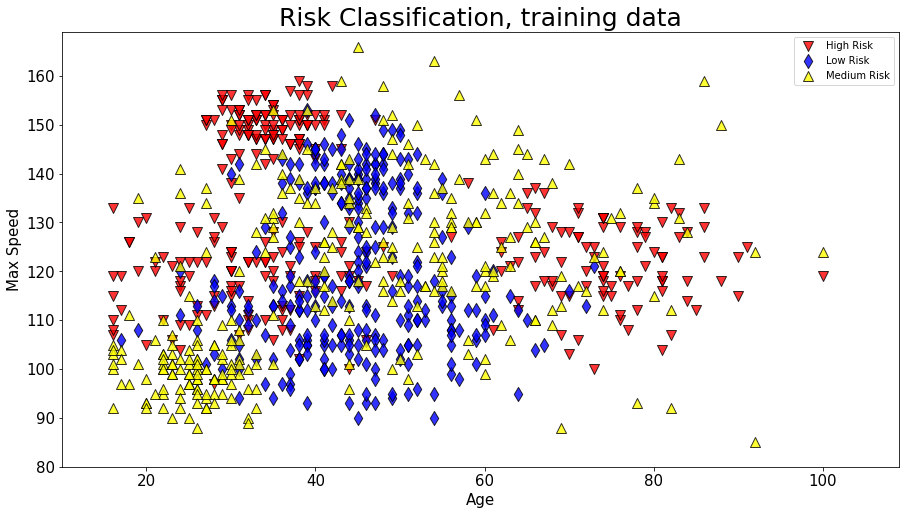

In [19]:
plotPrediction(clf=None, x_data=X_train[:, 1], y_data=X_train[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y_train,
                title="Risk Classification, training data");

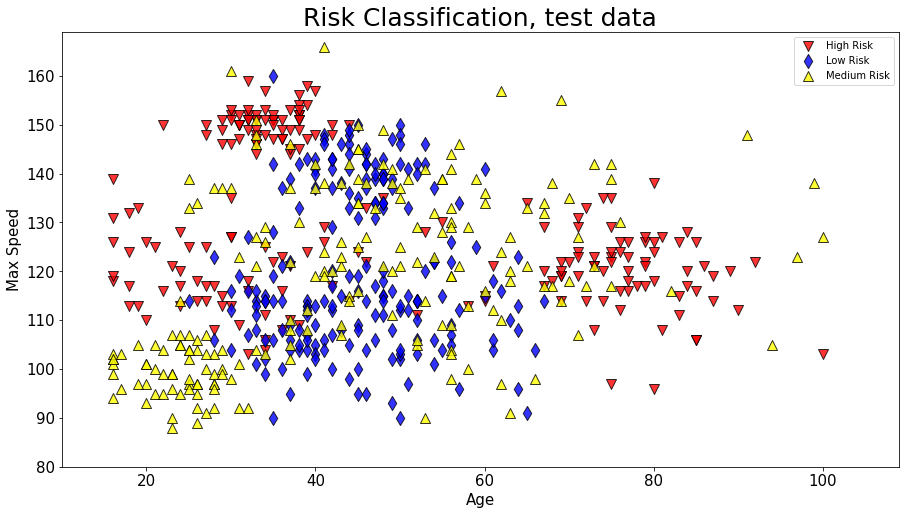

In [20]:
plotPrediction(clf=None, x_data=X_test[:, 1], y_data=X_test[:, 0], 
               x_label='Age', y_label='Max Speed', ground_truth=y_test,
               title="Risk Classification, test data");

# Step 2: Understanding why Decision Trees are inappropriate when trained traditionally

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
%time dt_model.fit(X_train_2_dim, y_train)

CPU times: user 2.04 ms, sys: 9 µs, total: 2.05 ms
Wall time: 2.06 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [22]:
dt_model.score(X_train_2_dim, y_train)

0.96

In [23]:
dt_model.score(X_test_2_dim, y_test)

0.6016666666666667

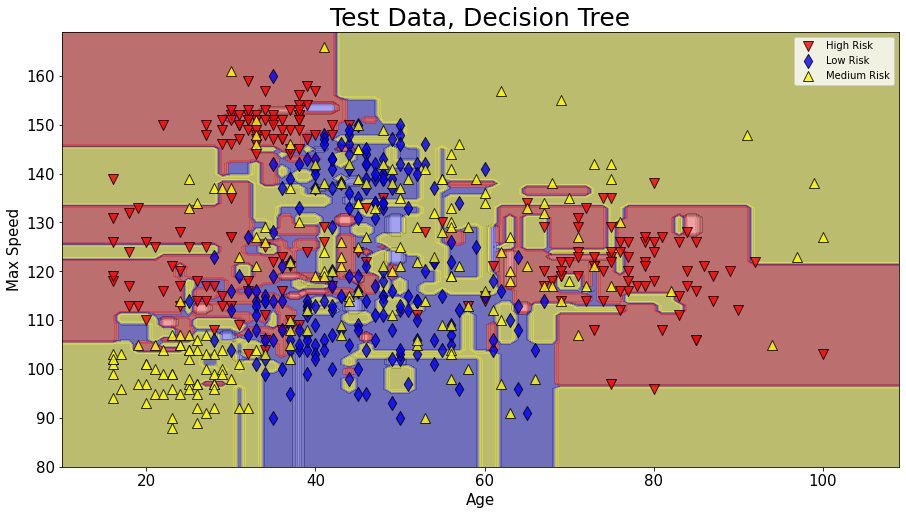

In [24]:
plotPrediction(dt_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree");

# Step 3: Train Neural Network using the data you have and make it generalize well


There are many ways of regualizing, and all work reasonably well on a problem like this, more on regualirization: https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/2020-01-basics-regularization.ipynb

Self-Normalizing Neural Networks (https://arxiv.org/abs/1706.02515)
* https://www.tensorflow.org/api_docs/python/tf/keras/activations/selu
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/AlphaDropout  

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, AlphaDropout

num_features = 2
num_categories = 3

dropout = 0.3
selu_dropout_model = tf.keras.Sequential()

selu_dropout_model.add(Input(name='input', shape=(num_features,)))

selu_dropout_model.add(Dense(name='hidden1', units=500, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
selu_dropout_model.add(AlphaDropout(dropout))

selu_dropout_model.add(Dense(name='hidden2', units=250, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
selu_dropout_model.add(AlphaDropout(dropout))

selu_dropout_model.add(Dense(name='output', units=num_categories, activation='softmax'))

selu_dropout_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

model = selu_dropout_model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 250)               125250    
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 250)               0         
_________________________________________________________________
output (Dense)               (None, 3)                 753       
Total params: 127,503
Trainable params: 127,503
Non-trainable params: 0
_________________________________________________________________


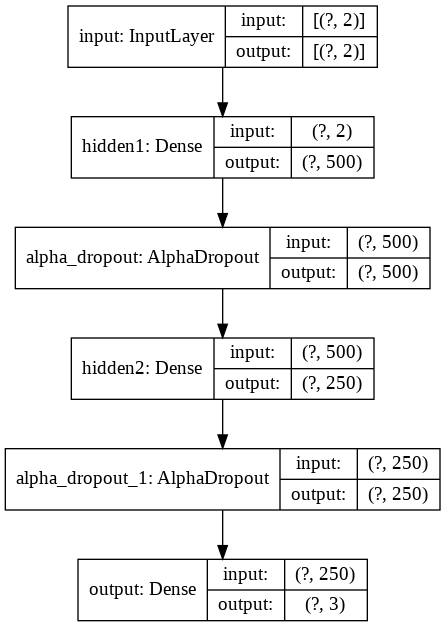

In [26]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=dpi)

In [27]:
%%time 

# BATCH_SIZE = 10
BATCH_SIZE = 500
EPOCHS = 3000

PATIENCE = 500
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE)

history = model.fit(x = X_train_2_dim,
                    y = y_train,
                    validation_data=(X_test_2_dim, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 49.3 s, sys: 4.18 s, total: 53.5 s
Wall time: 48.7 s


In [28]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.8408467372258505, 0.69777775)

In [29]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.8079651196797689, 0.7083333)

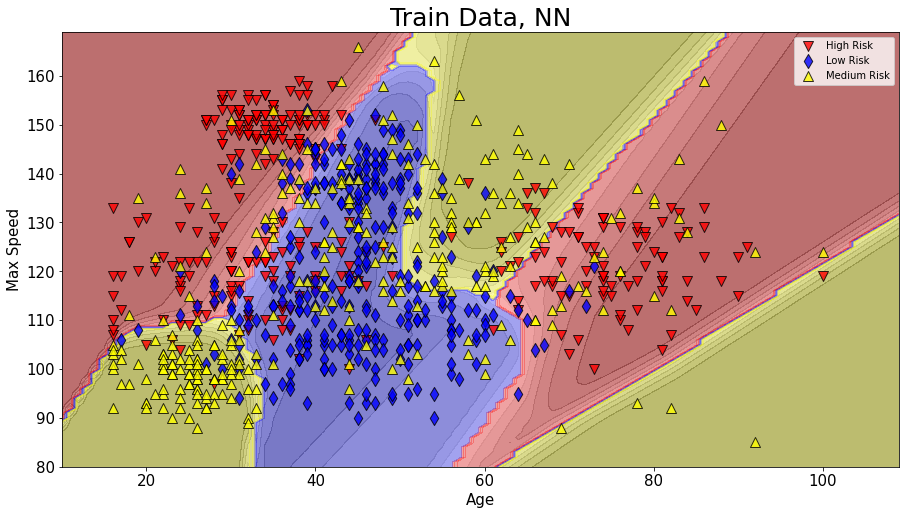

In [30]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, NN");

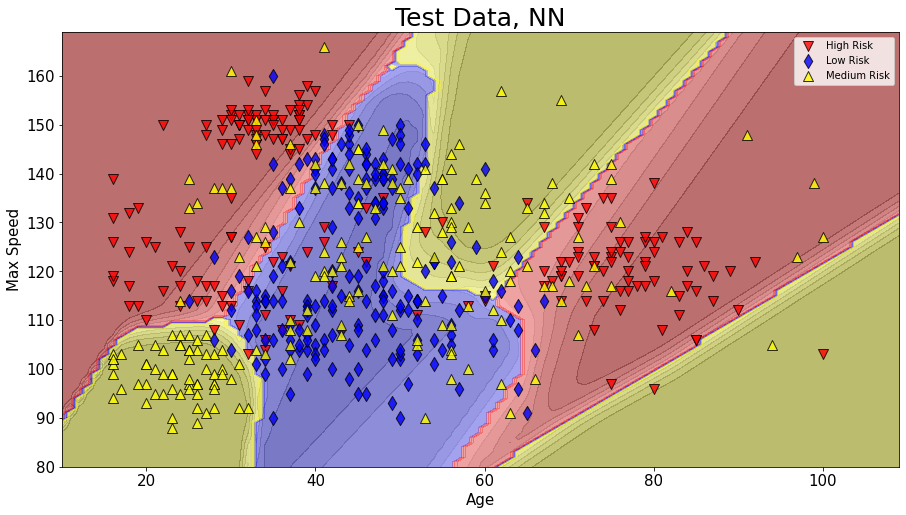

In [31]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN");

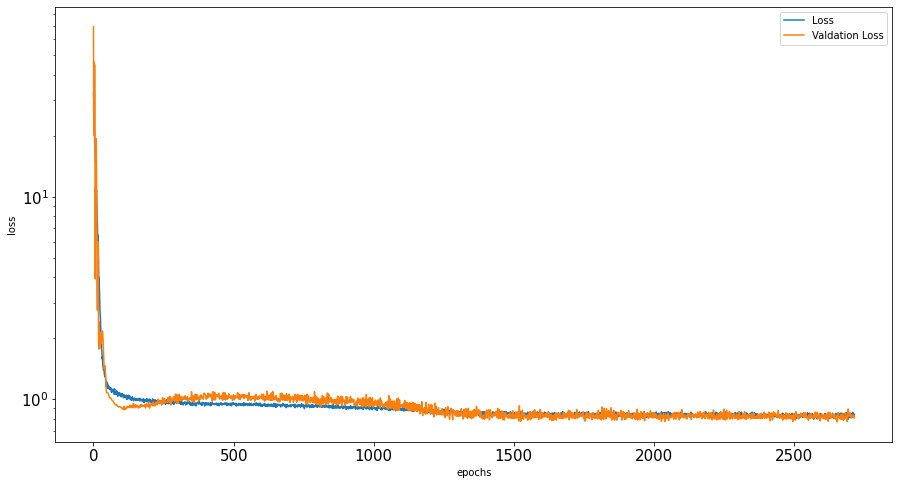

In [32]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"]);

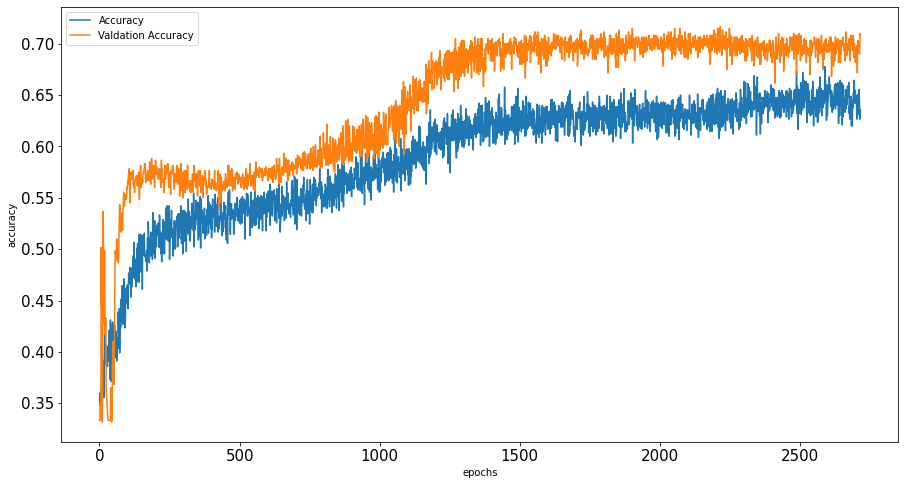

In [33]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"]);

# Step 4: Generate a larger and evenly distributed set of training data by feeding a grid of data through the neural network

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/teacher-samples.jpg?raw=1'>

In [34]:
xx,yy = meshGrid()
xx.shape, yy.shape

((90, 100), (90, 100))

In [35]:
mesh_data = np.c_[yy.ravel(), xx.ravel()]
mesh_data.shape

(9000, 2)

In [36]:
mesh_data[0]

array([80, 10])

In [37]:
pred = model.predict(mesh_data)
pred.shape

(9000, 3)

In [38]:
pred_sparse = pred.argmax(axis=1)
pred_sparse.shape

(9000,)

### Generated data is pretty much imbalanced

In [39]:
np.unique(pred_sparse, return_counts=True)

(array([0, 1, 2]), array([4212, 1684, 3104]))

# Step 5: Use this new training data to train a vanilla, unregularized decision tree

In [40]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier()
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 11.1 ms, sys: 1.11 ms, total: 12.3 ms
Wall time: 14.1 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

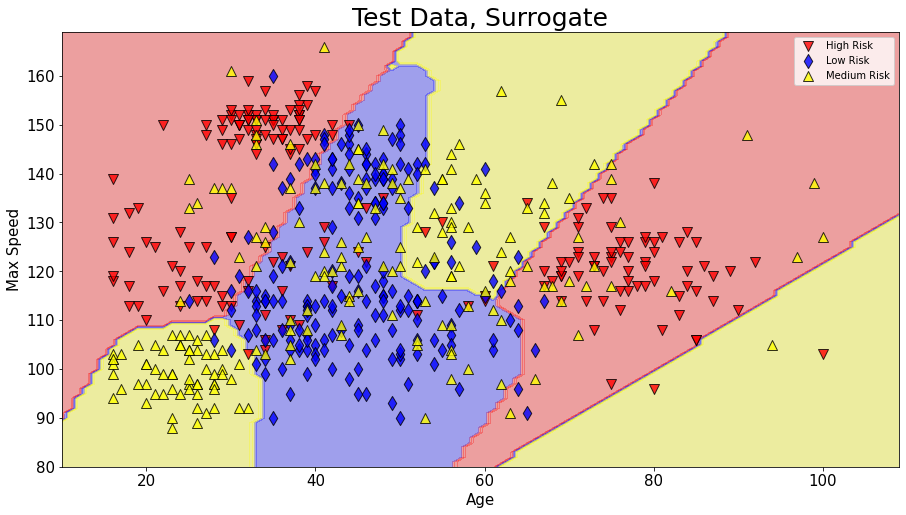

In [41]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

In [42]:
surrogate_model.tree_.max_depth

12

## Scores on newly generated data

In [43]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

## Scores on original data

In [44]:
surrogate_model.score(X_train_2_dim, y_train)

0.6977777777777778

In [45]:
surrogate_model.score(X_test_2_dim, y_test)

0.7083333333333334

# Step 6: Use typical regularization for decision tree not to make it generalize better, but to have a dial between explainability and accuracy


In [46]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    class_weight="balanced",
    random_state=random_seed,
    max_depth=3,
    max_leaf_nodes = 6,
)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 9.97 ms, sys: 787 µs, total: 10.8 ms
Wall time: 18.4 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=6,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [47]:
surrogate_model.tree_.max_depth

3

In [48]:
surrogate_model.score(mesh_data, pred_sparse)

0.7226666666666667

In [49]:
surrogate_model.score(X_train_2_dim, y_train)

0.5977777777777777

In [50]:
surrogate_model.score(X_test_2_dim, y_test)

0.6166666666666667

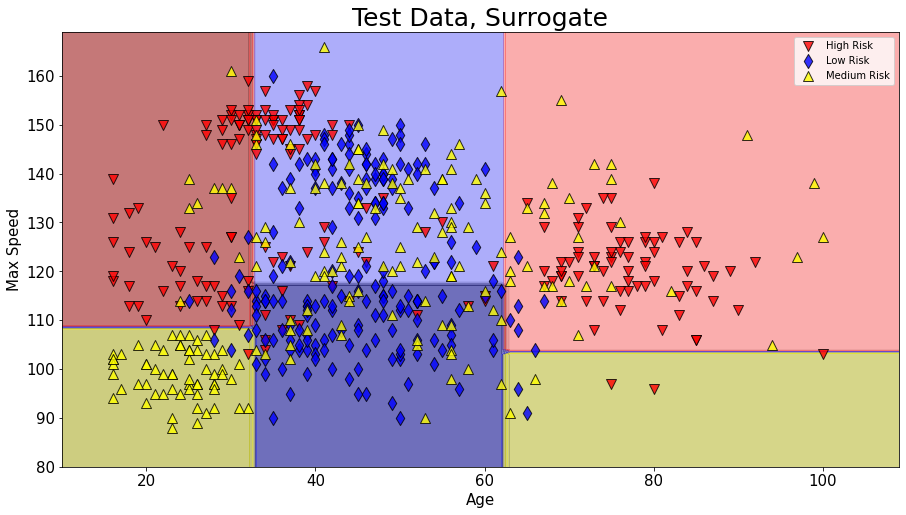

In [51]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

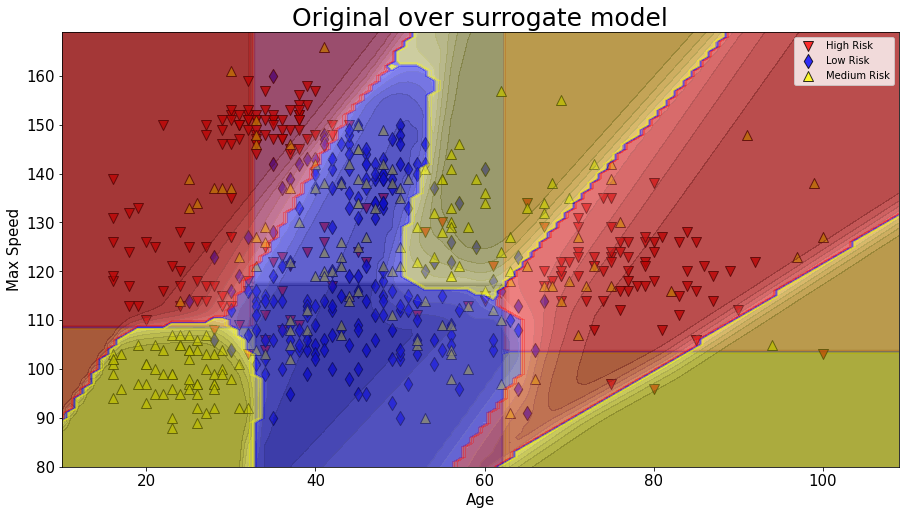

In [52]:
ax = plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test)
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, ax=ax, scatter=False,
                title="Original over surrogate model");

# Step 7: Use tree for explanation

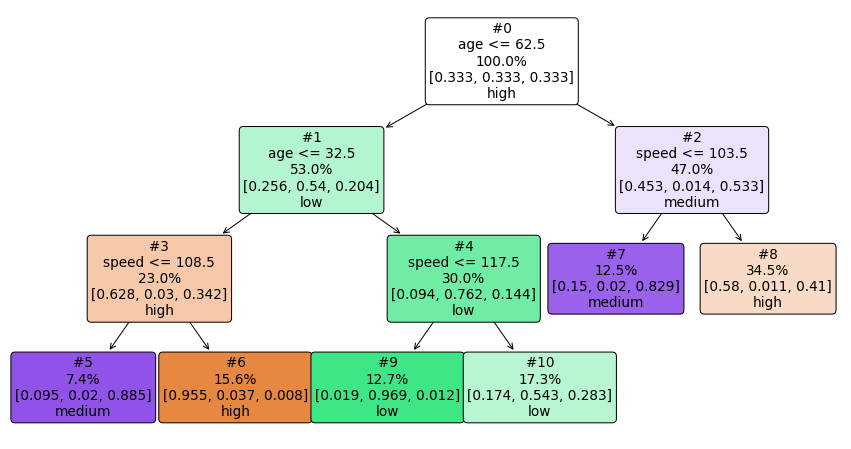

In [53]:
# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names=['speed', 'age']
class_names=['high', 'low', 'medium']

# plt.figure(figsize=(30, 10))
plot_tree(surrogate_model, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);

In [54]:
# groups: "High Risk", "Low Risk", "Medium Risk"

sample = [110, 35]
# sample = [100, 60]
# sample = [120, 17]

surrogate_model.predict([sample])

array([1])

## Visualizing Prediction Path using dtreeviz

https://github.com/parrt/dtreeviz

In [0]:
import sys

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


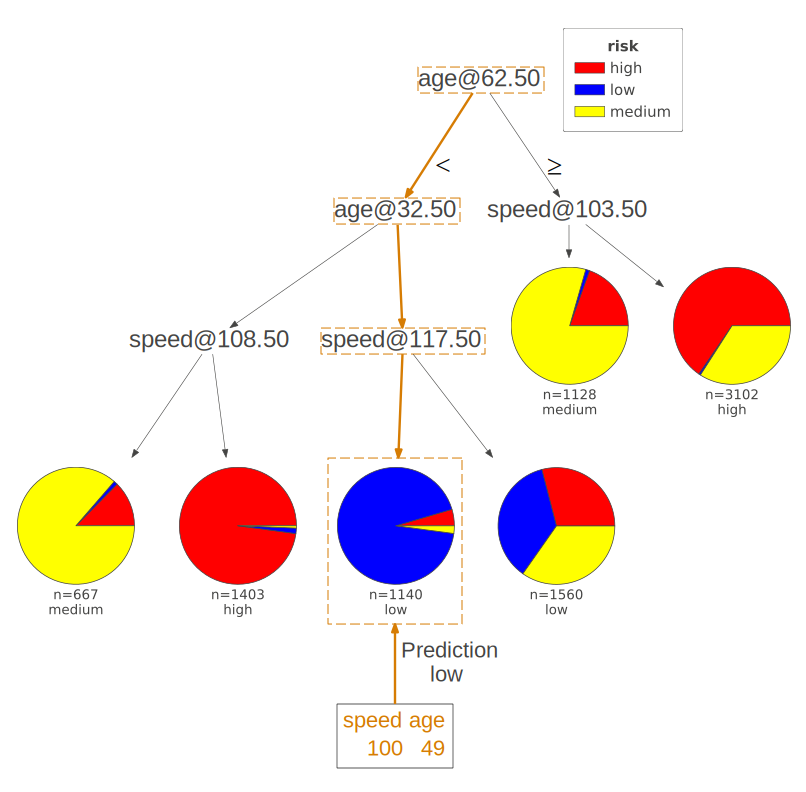

In [56]:
from dtreeviz.trees import dtreeviz

# sample = [100, 35]
# sample = [150, 30]
sample = [100, 49]
# sample = [100, 60]
# sample = [120, 17]

dtreeviz_colors = {'classes': [
                   None,  # 0 classes
                   None,  # 1 classes
                   None,  # 2 classes
                   colors
                   ]}

viz = dtreeviz(surrogate_model,
               mesh_data, pred_sparse,
               target_name='risk',
               feature_names=feature_names,
               class_names=class_names,
               X=sample,
               colors=dtreeviz_colors,
               fancy=False,
               scale=2,
#                scale=3
)
viz

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


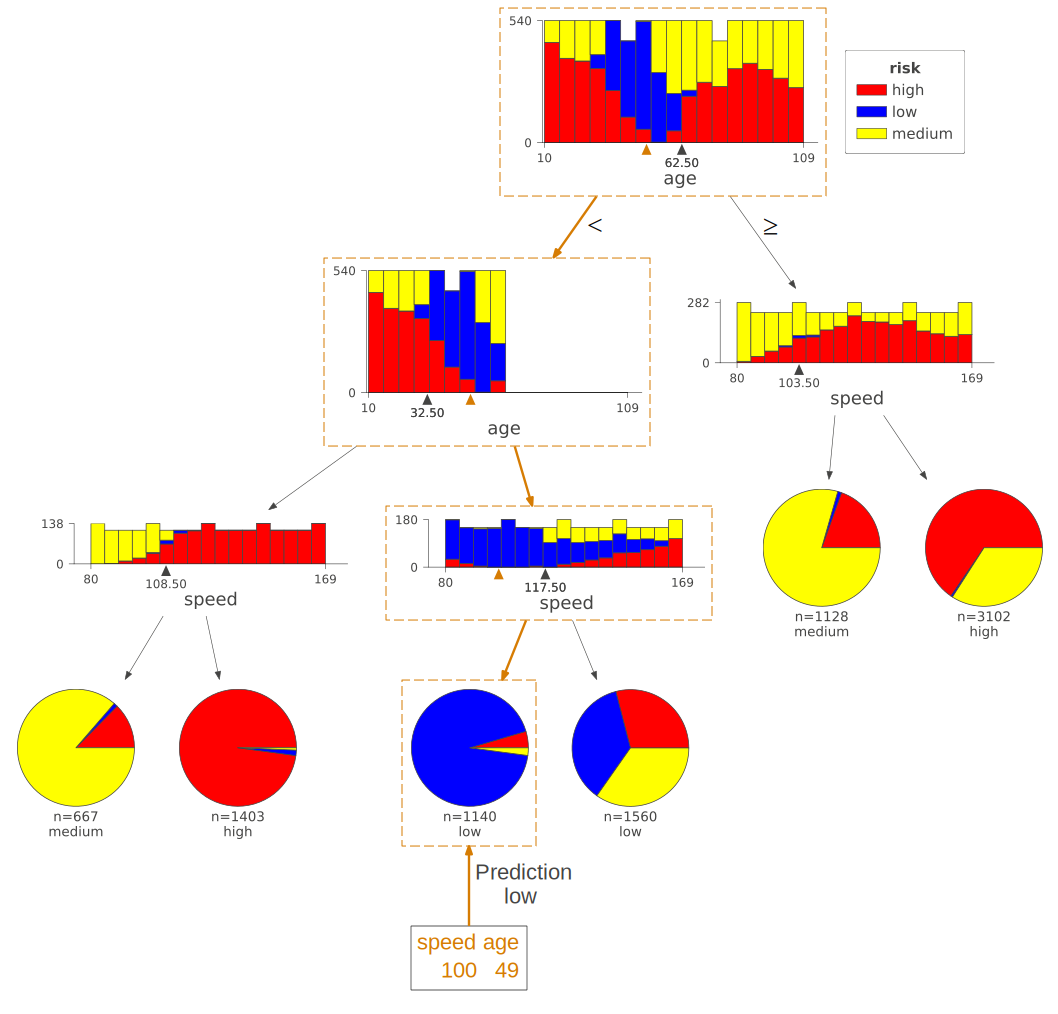

In [57]:
dtreeviz(surrogate_model,
         mesh_data, pred_sparse,
         target_name='risk',
         feature_names=feature_names,
         class_names=class_names,
         X=sample,
         colors=dtreeviz_colors,
         scale=2)

## Explaining decision


In [58]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

from sklearn.tree import _tree

def explain_decision(model, sample, feature_names, class_names):

  feature = model.tree_.feature
  threshold = model.tree_.threshold
  value = model.tree_.value

  node_indicator = model.decision_path([sample])
  node_index = node_indicator.indices[node_indicator.indptr[0]:
                                      node_indicator.indptr[1]]

  for node_id in node_index:
      if feature[node_id] == _tree.TREE_UNDEFINED:
          print(class_names[value[node_id].argmax(axis=1)[0]])
          continue

      if (sample[feature[node_id]] <= threshold[node_id]):
          threshold_sign = "<="
      else:
          threshold_sign = ">"

      print("%s(= %s) %s %s"
            % (feature_names[feature[node_id]],
              sample[feature[node_id]],
              threshold_sign,
              threshold[node_id]))
      
explain_decision(surrogate_model, sample, feature_names, class_names)      

age(= 49) <= 62.5
age(= 49) > 32.5
speed(= 100) <= 117.5
low


# Step 8: Feature Importance and unwanted Bias

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/bias_castro.jpg?raw=1'>

## Feature importance is biased in decison trees - but we fixed this along the way


this is because of the different numbers of values per feature, which we have fixed by having an equal number of samples for each feature

https://explained.ai/rf-importance/index.html#9
<br>
https://github.com/parrt/msds689/blob/master/projects/featimp/featimp.md


In [59]:
surrogate_model.feature_importances_

array([0.37014252, 0.62985748])

In [60]:
# https://scikit-learn.org/stable/modules/permutation_importance.html
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance
from sklearn.inspection import permutation_importance

permutation_importance(surrogate_model, mesh_data, pred_sparse)

{'importances': array([[0.16988889, 0.17288889, 0.17011111, 0.16911111, 0.161     ],
        [0.24888889, 0.25088889, 0.24455556, 0.25477778, 0.25055556]]),
 'importances_mean': array([0.1686    , 0.24993333]),
 'importances_std': array([0.004009  , 0.00330999])}

In [61]:
permutation_importance(surrogate_model, X_2_dim, y)

{'importances': array([[0.102     , 0.116     , 0.09733333, 0.104     , 0.10466667],
        [0.22533333, 0.22933333, 0.236     , 0.23733333, 0.23466667]]),
 'importances_mean': array([0.1048    , 0.23253333]),
 'importances_std': array([0.00615937, 0.00450974])}

## We train on all 3 features now

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, AlphaDropout

num_features = 3
num_categories = 3

dropout = 0.3
selu_dropout_model = tf.keras.Sequential()

selu_dropout_model.add(Input(name='input', shape=(num_features,)))

selu_dropout_model.add(Dense(name='hidden1', units=500, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
selu_dropout_model.add(AlphaDropout(dropout))

selu_dropout_model.add(Dense(name='hidden2', units=250, activation='selu', kernel_initializer=tf.initializers.lecun_normal(random_seed)))
selu_dropout_model.add(AlphaDropout(dropout))

selu_dropout_model.add(Dense(name='output', units=num_categories, activation='softmax'))

selu_dropout_model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy'])

model = selu_dropout_model

In [63]:
%%time 

# BATCH_SIZE = 10
BATCH_SIZE = 500
EPOCHS = 3000

PATIENCE = 500
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE)

history = model.fit(x = X_train,
                    y = y_train,
                    validation_data=(X_test, y_test),
                    epochs=EPOCHS, 
                    callbacks=[early_stopping_callback, KerasLearningCurve()],
                    # callbacks=[KerasLearningCurve()],
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 30.2 s, sys: 2.46 s, total: 32.7 s
Wall time: 29.6 s


In [64]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.7057153715027703, 0.77)

In [65]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.8005719284216563, 0.76666665)

In [0]:
def meshGrid3d(step=1):
    age_min, age_max = 10, 110
    speed_min, speed_max = 80, 170
    miles_min, miles_max = 1, 100
    xx, yy, zz = np.meshgrid(np.arange(age_min, age_max, step),
                         np.arange(speed_min, speed_max, step),
                         np.arange(miles_min, miles_max, step)
                         )
    return xx, yy, zz

In [0]:
# with step size 1 we will have almost a million data points
xx, yy, zz = meshGrid3d(step=2)
assert xx.shape == yy.shape == zz.shape

In [68]:
mesh_data = np.c_[yy.ravel(), xx.ravel(), zz.ravel()]
mesh_data.shape

(112500, 3)

In [69]:
mesh_data[0], mesh_data[10000]

(array([80, 10,  1]), array([88, 10,  1]))

In [70]:
%%time

pred = model.predict(mesh_data)
pred.shape

CPU times: user 4.68 s, sys: 406 ms, total: 5.09 s
Wall time: 3.85 s


In [71]:
pred_sparse = pred.argmax(axis=1)
pred_sparse.shape

(112500,)

### Generated data is pretty much imbalanced

In [72]:
# groups: "High Risk", "Low Risk", "Medium Risk"

np.unique(pred_sparse, return_counts=True)

(array([0, 1, 2]), array([26124,  6419, 79957]))

In [73]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier()
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 116 ms, sys: 4.96 ms, total: 121 ms
Wall time: 124 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [74]:
surrogate_model.tree_.max_depth

20

In [75]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

In [76]:
surrogate_model.score(X_train, y_train)

0.7622222222222222

In [77]:
surrogate_model.score(X_test, y_test)

0.7666666666666667

In [78]:
surrogate_model.feature_importances_

array([0.21044254, 0.32656461, 0.46299285])

In [79]:
# https://scikit-learn.org/stable/modules/permutation_importance.html
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance
from sklearn.inspection import permutation_importance

permutation_importance(surrogate_model, mesh_data, pred_sparse)['importances_mean']

array([0.20634844, 0.28753067, 0.34610667])

In [80]:
permutation_importance(surrogate_model, X, y)['importances_mean']

array([0.2       , 0.34066667, 0.24813333])

In [81]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    max_depth=4,
    criterion='entropy',
    random_state=random_seed,
    # splitter='random',
    min_samples_leaf = 500,
    max_leaf_nodes = 10,
    class_weight="balanced"
)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 81.3 ms, sys: 0 ns, total: 81.3 ms
Wall time: 82 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=4, max_features=None,
                       max_leaf_nodes=10, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=500,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=42, splitter='best')

In [82]:
surrogate_model.tree_.max_depth

4

In [83]:
surrogate_model.score(mesh_data, pred_sparse)

0.7862044444444445

In [84]:
surrogate_model.score(X_train, y_train)

0.5977777777777777

In [85]:
surrogate_model.score(X_test, y_test)

0.61

In [86]:
surrogate_model.feature_importances_

array([0.06670986, 0.52151563, 0.41177452])

In [87]:
permutation_importance(surrogate_model, mesh_data, pred_sparse)['importances_mean']

array([0.02663644, 0.15523378, 0.25763022])

In [88]:
permutation_importance(surrogate_model, X, y)['importances_mean']

array([0.0264    , 0.21573333, 0.13133333])

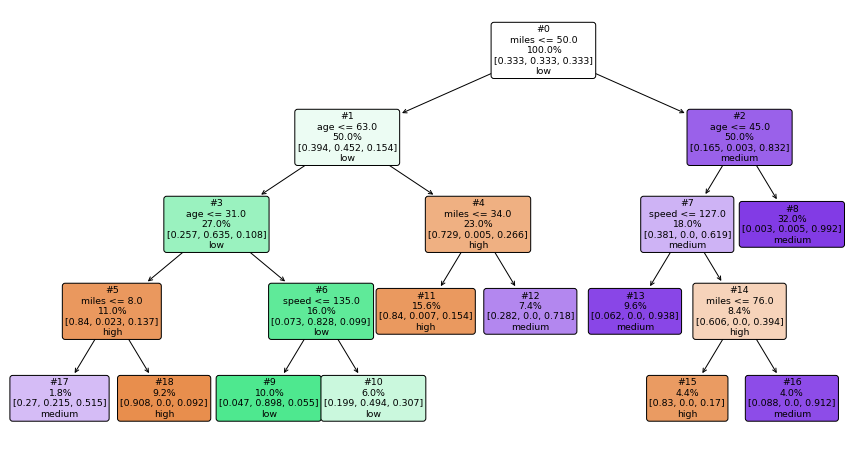

In [89]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names=['speed', 'age', 'miles']
class_names=['high', 'low', 'medium']

# plt.figure(figsize=(30, 10))
plot_tree(surrogate_model, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);

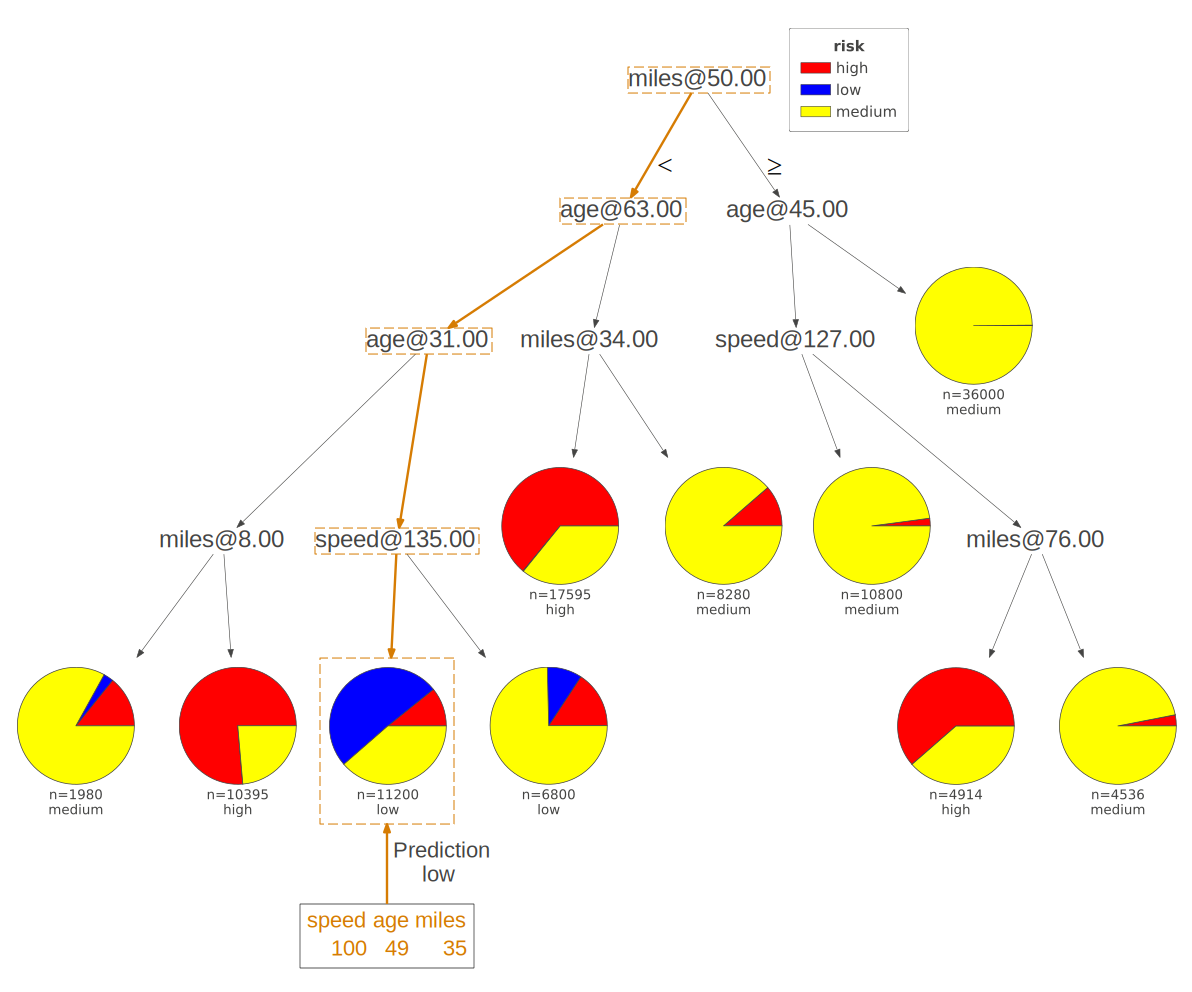

In [90]:
from dtreeviz.trees import dtreeviz

sample = [100, 49, 35]

dtreeviz_colors = {'classes': [
                   None,  # 0 classes
                   None,  # 1 classes
                   None,  # 2 classes
                   colors
                   ]}

viz = dtreeviz(surrogate_model,
               mesh_data, pred_sparse,
               target_name='risk',
               feature_names=feature_names,
               class_names=class_names,
               X=sample,
               colors=dtreeviz_colors,
               fancy=False,
               scale=2,
#                scale=3
)
viz

## Just an experiment: Trying to predict one of the columns from the others

Why can we not do this on mesh data????

In [91]:
# groups: "High Risk", "Low Risk", "Medium Risk"

np.unique(pred_sparse, return_counts=True)

(array([0, 1, 2]), array([26124,  6419, 79957]))

In [92]:
# groups: "High Risk", "Low Risk", "Medium Risk"

np.unique(y, return_counts=True)

(array([0, 1, 2]), array([501, 500, 499]))

In [93]:
# mesh_data.shape
mesh_X = mesh_data[:, 0:2]
mesh_y = mesh_data[:, -1]

mesh_X.shape, mesh_y.shape

((112500, 2), (112500,))

In [94]:
clf = DecisionTreeClassifier(random_state=random_seed, class_weight="balanced")
clf.fit(mesh_X, mesh_y)
clf.score(mesh_X, mesh_y)

0.02

In [95]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=random_seed, class_weight="balanced")
clf.fit(mesh_X, mesh_y)
clf.score(mesh_X, mesh_y)

0.02

In [96]:
mesh_X = X[:, 0:2]
mesh_y = X[:, -1]

clf = DecisionTreeClassifier(random_state=random_seed)
clf.fit(mesh_X, mesh_y)
clf.score(mesh_X, mesh_y)

0.7853333333333333

# Summary

Our approach: _teach a decision tree using a stronger model (like a neural network) to fight overfitting, but still having all the benefits of a decision tree (like feature importance, uncertainty quantification, and explainability_

* Decision trees are great for explainability
  * can quantity uncertainty 
  * give you feature importance
  * can be made shallow and thus interpretable
  * can be used for debugging, finding unwanted bias, and genereally give explainability
* they, however, overfit no matter what you do
* using a neural network as a teacher lets them overfit on very general data
  * this can be seen as a form of data augmentation
* combines the best of both worlds  

# Thank you and questions

## More on surrogate models
* https://en.wikipedia.org/wiki/Surrogate_model
* https://christophm.github.io/interpretable-ml-book/global.html

## And on model interpretation in general
* https://christophm.github.io/interpretable-ml-book/simple.html
* https://compstat-lmu.github.io/iml_methods_limitations/

# Annotated Poster from http://scaledml.org/2020/  
![Poster Scaled ML 2020](https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/interp/poster-scaled-ml-2020.jpg?raw=1)

https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-surrogate-model.ipynb
https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-surrogate-model-details.ipynb